---
Matplotlib settings gor JN
---

In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: #797D7F30 !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

---
Main imports
---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import gc
import sys

---
Data analysis
---

loading data

In [120]:
data_pd = pd.read_csv('./data/raw_data.txt', sep=r'\s+', header=None)
data_pd.columns = ['m1', 'm2', 'x', 'theta', 'P1', 'P2']

visualisation

In [121]:
data_pd

,m1,m2,x,theta,P1,P2
0,1.0,1.5,-0.01,0.0,0.12349,0.12349
1,1.0,1.5,-0.01,30.0,0.11634,0.08993
2,1.0,1.5,-0.01,60.0,0.09855,0.02890
3,1.0,1.5,-0.01,90.0,0.07791,0.00028
4,1.0,1.5,-0.01,120.0,0.06095,0.01244
...,...,...,...,...,...,...
751,1.5,1.7,-0.09,60.0,2.18423,1.40168
752,1.5,1.7,-0.09,90.0,0.91968,0.32984
753,1.5,1.7,-0.09,120.0,0.31187,0.07966
754,1.5,1.7,-0.09,150.0,0.17554,0.12959


In [122]:
print('m1 :', set(data_pd['m1']))
print('m2 :', set(data_pd['m2']))
print(' x :', set(data_pd['x']))
print(' t :', set(data_pd['theta']))

m1 : {0.9, 1.0, 0.6, 0.8, 0.7, 1.1, 1.2, 1.3, 1.4, 1.5}
m2 : {1.7, 1.5, 1.6}
 x : {-0.05, -0.03, -0.06, -0.07, -0.08, -0.09, -0.1, -0.02, -0.04, -0.01}
 t : {0.0, 180.0, 150.0, 120.0, 90.0, 60.0, 30.0}


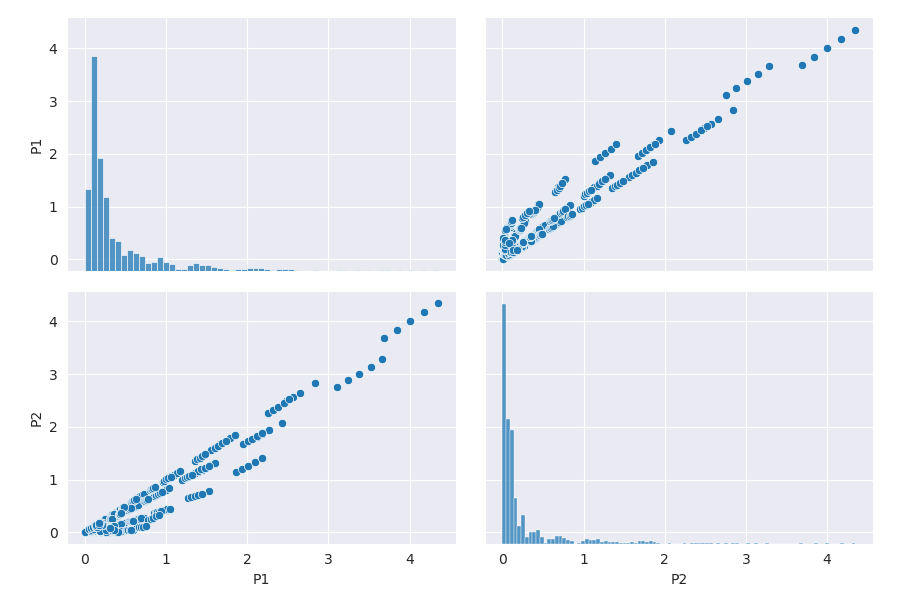

In [123]:
with sns.axes_style("darkgrid"):
    g = sns.PairGrid(data_pd, vars=['P1', 'P2'],
                     height=3, aspect=1.5)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)

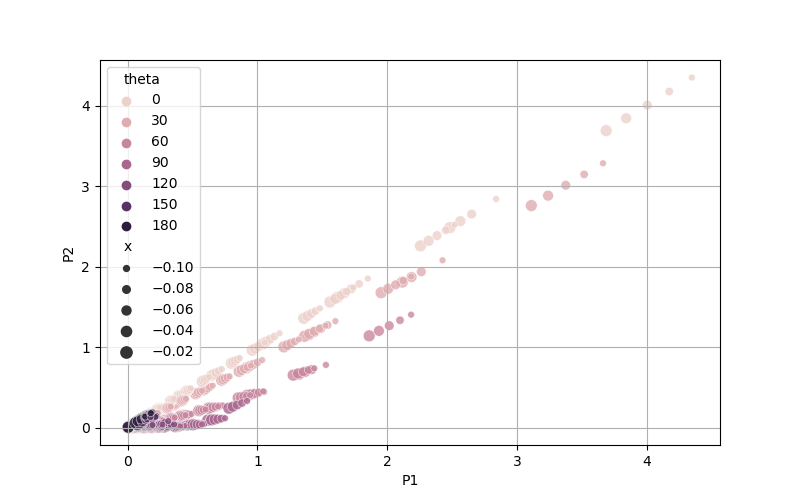

In [124]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data_pd, x='P1', y='P2', 
                hue='theta', size='x', 
                alpha=0.8, ax=ax)
plt.grid()

---
Infrastrucrue
---

In [4]:
import torch
from sklearn.model_selection import train_test_split

from torch import tensor, cat
from torch.utils.data import Dataset

In [5]:
class Normalisator():
    def __init__(self, pd_data):
        tensor_data = tensor(np.array(pd_data, dtype=np.float32))
        self.norm_means = cat([tensor_data[:, 0:4].mean(axis=0), torch.zeros(2)])
        self.norm_stds = cat([tensor_data[:, 0:4].std(axis=0), torch.ones(2)])
        self.tensor_norm = self.normalise(tensor_data)
    
    def get_normalised_tensor(self):
        return self.tensor_norm

    def normalise(self, tensor):
        if tensor.shape[1] == 6:
            return (tensor - self.norm_means) / self.norm_stds
        if tensor.shape[1] == 4:
            return (tensor - self.norm_means[:, 0:4]) / self.norm_stds[:, 0:4]
        else:
            raise ValueError()

    def denormalise(self, tensor):
        if tensor.shape[1] == 6:
            return tensor * self.norm_stds + self.norm_means
        if tensor.shape[1] == 4:
            return tensor * self.norm_stds[:, 0:4] + self.norm_means[0, 0:4]
        else:
            raise ValueError()


class MyDataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)
    
    def __getitem__(self, idx):
        row = self.tensor[idx]
        return row[0:4], row[4:6]

    def get_x(self):
        return self.tensor[:, 0:4]
    
    def get_y(self):
        return self.tensor[:, 4:6]

---
Save/load data
---

create tensors

In [ ]:
normalistion = Normalisator(data_pd)
norm_datas_tensor = normalistion.get_normalised_tensor()

In [ ]:
train_tensor, test_tensor = train_test_split(norm_datas_tensor, test_size=0.25)

save tensors

In [7]:
torch.save(train_tensor, './data/train_tensor.t')
torch.save(test_tensor, './data/test_tensor.t')

NameError: name 'train_tensor' is not defined

load tensors

In [8]:
train_tensor = torch.load('./data/train_tensor.t')
test_tensor = torch.load('./data/test_tensor.t')

create datasets from tensors

In [15]:
train_dataset = MyDataset(train_tensor)
test_dataset = MyDataset(test_tensor)

---
Models
---

In [10]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.seq = torch.nn.Sequential(
            torch.nn.Linear(4, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.seq(x)


In [11]:
class ReLUNet(torch.nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()

        self.seq = torch.nn.Sequential(
            torch.nn.Linear(4, 80),
            torch.nn.ReLU(),
            torch.nn.Linear(80, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 80),
            torch.nn.ReLU(),
            torch.nn.Linear(80, 2),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)

---
Learning
---

In [106]:
if 'model' in locals():
    del model
gc.collect()

1621

In [107]:
model = ReLUNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
model_loss = torch.nn.MSELoss()

epochs = 80
batch_size = 30

In [108]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

running_loss = []
test_loss = []

traits = test_dataset.get_x()
targets = test_dataset.get_y()
result = model(traits)
test_loss.append(model_loss(targets, result).item())


for epo in range(epochs):
    sys.stdout.write(f'# inside epoch {epo+1:>3} \r')
    sys.stdout.flush()
    model.train()

    i = 0 
    for traits, targets in train_loader:
        i += 1
        evaluated = model(traits)
        loss = model_loss(evaluated, targets)

        running_loss.append(loss.item())
        # sys.stdout.write(f'{i} -- {loss.item()}\r')
        # sys.stdout.flush()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    traits = test_dataset.get_x()
    targets = test_dataset.get_y()
    result = model(traits)
    test_loss.append(model_loss(targets, result).item())

    scheduler.step()
    model.eval()

print('\n\n# test loss = ', test_loss[-1])

# inside epoch  80 

# test loss =  0.00025509585975669324


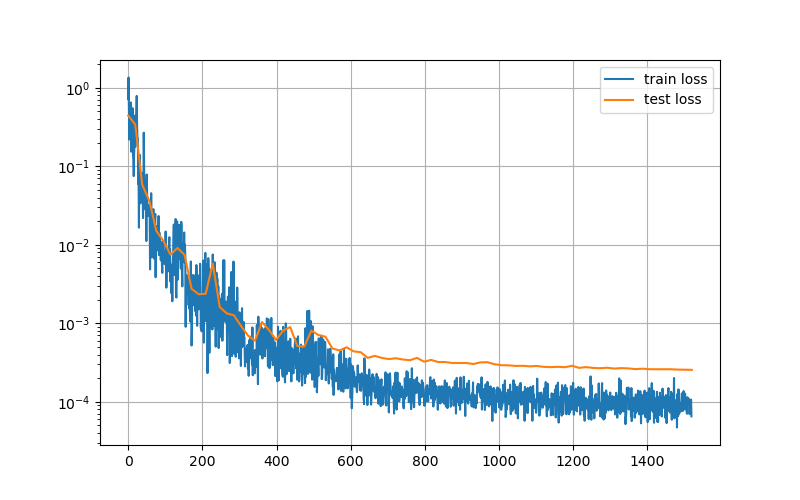

In [109]:
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(running_loss, label='train loss')
plt.plot([(i) * len(running_loss) / (len(test_loss)-1) for i in range(len(test_loss))], test_loss,
         label = 'test loss')
plt.yscale('log')
plt.legend()
plt.grid()

---
Save/load model
---

best models (mse_loss):

- ReLuNet_01 (0.000164)
- ReLuNet_02 (0.000224)
- ReLuNet_03 (0.000221)
- ReLuNet_04 (0.000252)
- ReLuNet_05 (0.000255)

In [110]:
torch.save(model.state_dict(), './models/ReLuNet_05.pth')

In [118]:
model = ReLUNet()
# model = SimpleNet()
model.load_state_dict(torch.load('./models/ReLuNet_01.pth'))

<All keys matched successfully>

---
Model analysis
---

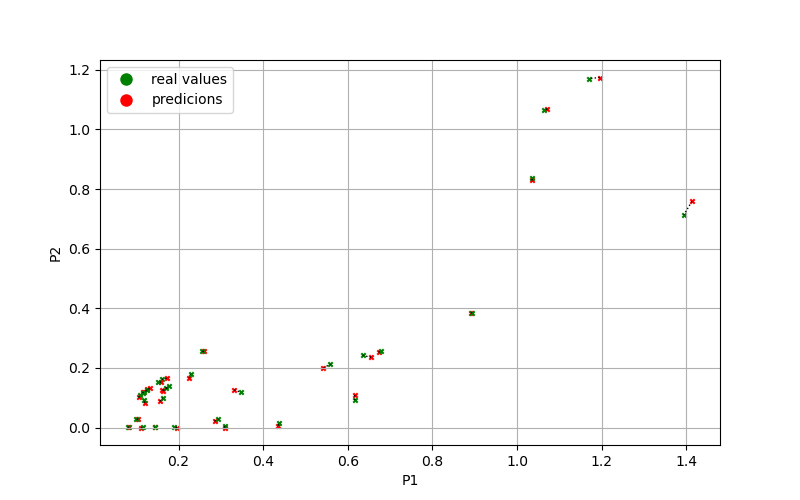

In [119]:
fig, ax = plt.subplots(figsize=(8,5))

for i in range(30):
    traits, result = test_dataset[i]
    pred = model(traits).detach().numpy()
    
    plt.scatter(*pred, c='red', s=10, marker='x')
    plt.scatter(*result, c='green', s=10, marker='x')

    plt.plot([pred[0], result[0]], [pred[1], result[1]],
             ls=':', c='black', lw=1)


legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color='w', label='real values', markerfacecolor='green', markersize=10), 
                   mpl.lines.Line2D([0], [0], marker='o', color='w', label='predicions', markerfacecolor='red', markersize=10)]
ax.legend(handles=legend_elements)

plt.grid()
plt.xlabel('P1')
plt.ylabel('P2')
plt.show()

---
Models ansamble
---

Averaging models results to increase precision

In [113]:
models = list()
for i in [1, 2, 3, 4, 5]:
    model = ReLUNet()
    model.load_state_dict(torch.load(f'./models/ReLuNet_0{i}.pth'))
    models.append(model)

In [114]:
traits = test_dataset.get_x()
targets = test_dataset.get_y()

for model in models:
    result = model(traits)
    print(model_loss(targets, result).item())

0.00016418487939517945
0.0002243180206278339
0.00022112533042673022
0.00025248437304981053
0.00025509585975669324


In [116]:
traits = test_dataset.get_x()
targets = test_dataset.get_y()

results = list()
for model in models:
    result = model(traits)
    results.append(result)

mean_result = sum(results) / len(results)
print(model_loss(targets, mean_result).item())

0.00010792343528009951


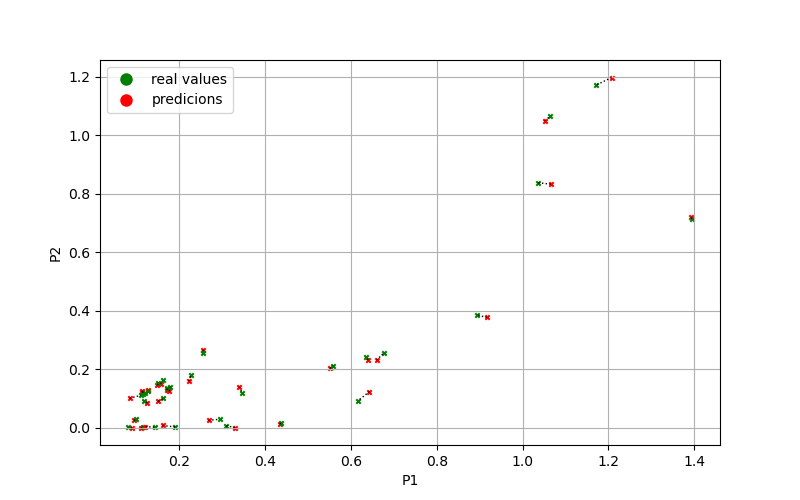

In [117]:
fig, ax = plt.subplots(figsize=(8,5))

for i in range(30):
    traits, result = test_dataset[i]
    preds = list()
    for model in models:
        pred =  model(traits).detach().numpy()
        preds.append(pred)
    
    mean_pred = sum(preds) / len(preds)

    plt.scatter(*pred, c='red', s=10, marker='x')
    plt.scatter(*result, c='green', s=10, marker='x')

    plt.plot([pred[0], result[0]], [pred[1], result[1]],
             ls=':', c='black', lw=1)


legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color='w', label='real values', markerfacecolor='green', markersize=10), 
                   mpl.lines.Line2D([0], [0], marker='o', color='w', label='predicions', markerfacecolor='red', markersize=10)]
ax.legend(handles=legend_elements)

plt.grid()
plt.xlabel('P1')
plt.ylabel('P2')
plt.show()